# Introduction

The dataset consists of 250 aerial images (64 x 64 pixels), 50 images per class; grass, rocks, trees, zebra and wildebeest. 

**Objective**: "*To classify the content of each image*"

Let us load the packages needed for subsequent analysis and set a few constants 

In [1]:
# Enable inline plotting in Jupyter
%matplotlib inline

#-----------------------------------------------------------------------------#
# Preamble
#-----------------------------------------------------------------------------#
# Import Packages/Modules needed for subsequent analyses
import os
import numpy as np
import warnings # to create a warning
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # Principal component analysis
from sklearn.ensemble import RandomForestClassifier # Random Forest classifier
from sklearn.metrics import confusion_matrix # To compute Confusion Matrix
from sklearn.cross_validation import StratifiedShuffleSplit # Train/Test split
# "Local" Modules
from circularHOGExtractor import circularHOGExtractor # HOGs features
import tsne # t-Distributed Stochastic Neighbor Embedding (t-SNE) 

# Constants
BINS=16     # number of bins in the radial direction for large scale features
SIZE=2     # (2 if using lo-res) size of bin in pixels, this sets the required radius for the image = bins*size
MAX_FREQ=4 # number of fourier modes that will be used (0:modes-1)
CLASSES = ['grass', 'rocks', 'trees', 'zebra', 'wildebeest'] # the different classes to discriminate
DIR_NAME = 'images' # name of directory where images are stored
NIMAGES = 50 # 50 photos in total in each class
NPIXELS = 64 # images are 64 x 64 pixels

# Feature Extraction

Photos are complex high-dimensional objects. We need to find ways to represent these images that best discriminate between classes. Here we consider two types of feature sets:

1. Raw: Simply the intensity of every pixel (image converted to greyscale); featRaw = 250 images x 4096 features 
2. HOGs: Histogram of Oriented Gradients (HOGs); hand-crafted features that relate to the shape of object in image (see manuscript for references); featHOG = 250 images x 1350 features

Both feature sets are normalised and we perform a very crude feature selection on the HOGs by removing those features which have very little variability across images, and therefore are unlikely to provide any predictive capacity.

In [2]:
#-----------------------------------------------------------------------------#
# Initialise objects
#-----------------------------------------------------------------------------#
ch = circularHOGExtractor(BINS, SIZE, MAX_FREQ) # object to extract features from an image
NFeats = ch.getNumFields() # number of features per image 
featRaw = np.empty((len(CLASSES)*NIMAGES, NPIXELS*NPIXELS)) # 250 images x 4096 pixel values - raw features
featHOG = np.empty((len(CLASSES)*NIMAGES, NFeats)) # 250 images x 1350 HOGs features
classLabel = np.empty(len(CLASSES)*NIMAGES, dtype='S10') # 'zebra', 'grass', etc. 

#-----------------------------------------------------------------------------#
# Loop through all images and create a feature vector
# 1) Naive - simply the gray scale values
# 2) HOG - Histogram of oriented gradients
#-----------------------------------------------------------------------------#
iCnt = 0 # an overall counter
for cls in CLASSES:
    lst = [name for name in os.listdir(DIR_NAME + os.sep + cls) if not name.startswith('.')] 
    for imName in lst:
        fileName = DIR_NAME + os.sep + cls + os.sep + imName # e.g images/zebra/img-93834.png
        colorImage = cv2.imread(fileName) # read image
        grayImage = cv2.cvtColor(colorImage, cv2.COLOR_BGR2GRAY) # convert to grayscale
        featRaw[iCnt, :] = grayImage.astype(float).ravel()/255.0 # keep it between 0 and 1  
        featHOG[iCnt, :] = ch.extract(grayImage) # extract HOGs features
        classLabel[iCnt] = cls # label the image
        iCnt = iCnt + 1 # update overall counter

# Normalise HOGs features and remove features with very little variability 
featHOG = featHOG/featHOG.max()
stdHOG = featHOG.std(axis=0) # compute standard deviation
featHOG = featHOG[:, stdHOG>=0.005] # crude feature selection 1350 features --> 1012 features

# Visualisation

Now that we have a set of features (Naive and HOGs) we will use linear (PCA) and non-linear (t-SNE) dimensionality reduction techniques to visualise the data and see whether we can detect some structure in the data.

In [3]:
def plot2D(embedding, labels, figName, legLoc='best'):
    
    """
    A utility function to plot the 2D embedding of a high-dimensional dataset

    Arguments
    =========
    embedding - a 2D numpy array from PCA or t-SNE (N x 2)
    labels - the class of each datapoint (N x 1)
    figName - name of title/figure
    legLoc - location of legend
    
    Returns
    =========
    Annotated 2D plot

    """
    # Initialise 
    # Class colour when plotting: grass(green)/rocks(red)/trees(orange)/wildebeest(blue)/zebra(purple)
    CLASS_COL = [(0.3, 0.7, 0.3), (0.9, 0.1, 0.1), (1, 0.5, 0), (0.2, 0.5, 0.7), (0., 0., 0.)] 
    N, D = embedding.shape # N - no. of images, D - no. of dimensions
    # Plot embedding    
    if D!=2:
        warnings.warn("Can only plot 2D embeddings", UserWarning)
    else:
        # Create figure
        hFig = plt.figure(num=figName, figsize=(8, 6))
        hAx = hFig.gca()                   
        hPlot = [] # plot handles (each class is a separate plot)
        # Loop through each label and plot its datapoints
        for i, label in enumerate(np.unique(labels)):
            x = embedding[labels==label, 0]
            y = embedding[labels==label, 1]
            hPlot.append(hAx.scatter(x, y, marker='o', linewidth='0', c=CLASS_COL[i])) 
        # Set plot parameters
        hAx.legend(hPlot, np.unique(labels), scatterpoints=1, loc=legLoc)
        hAx.set_title(figName)
        xMin, yMin = embedding.min(axis=0) # 1 x 2 array           
        xMax, yMax = embedding.max(axis=0) # 1 x 2 array             
        xMin, xMax = xMin-0.1*(xMax-xMin), xMax+0.1*(xMax-xMin)
        yMin, yMax = yMin-0.1*(yMax-yMin), yMax+0.1*(yMax-yMin)                  
        hAx.set_xlim(xMin, xMax)
        hAx.set_ylim(yMin, yMax)
        hAx.set_xlabel('embedding 1')
        hAx.set_ylabel('embedding 2')

## Raw features

We start by looking at the raw feature set. The PCA plot does not reveal obvious clusters, but the t-SNE does show some structure, although it's not very clear. 

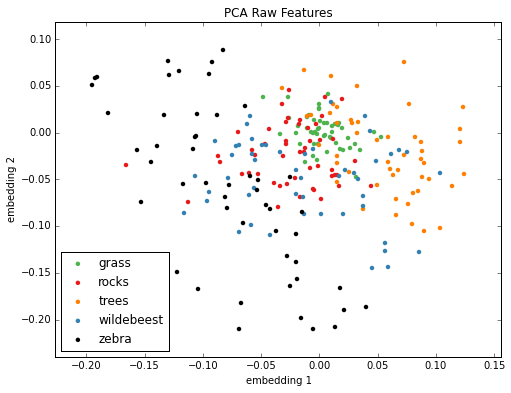

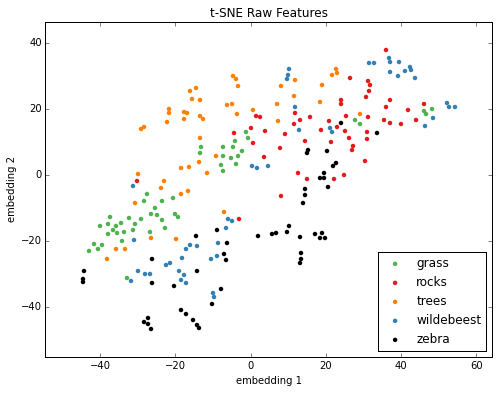

In [7]:
#-----------------------------------------------------------------------------#
# Visualise high-dimensional data
#-----------------------------------------------------------------------------#
k = 2 # 2D projection
seed=20 # to reproduce t-SNE results
# PCA
pcaOut = PCA(n_components=k)
pcaOut.fit(featRaw.T)
embedding = pcaOut.components_.T
plot2D(embedding, classLabel, "PCA Raw Features", "lower left")
# t-SNE
embedding = tsne.tsne(featRaw, no_dims=k, initial_dims=20, perplexity=10.0, seed=seed)
plot2D(embedding, classLabel, "t-SNE Raw Features", "lower right")

## HOGs features

We now look at the hand-crafted features. The PCA plot show reasonable structure, although all classes seem to be "bunched up" together. The t-SNE plot shows clear separation between classes.

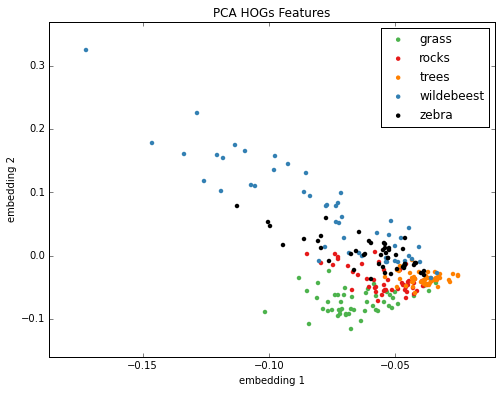

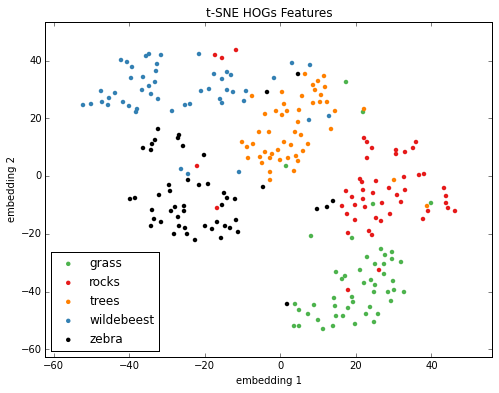

In [5]:
# PCA
pcaOut = PCA(n_components=k)
pcaOut.fit(featHOG.T)
embedding = pcaOut.components_.T
plot2D(embedding, classLabel, "PCA HOGs Features", "upper right")
# t-SNE
embedding = tsne.tsne(featHOG, no_dims=k, initial_dims=20, perplexity=10.0, seed=seed)
plot2D(embedding, classLabel, "t-SNE HOGs Features", "lower left")

# Predictive Modelling

The above data visualisation suggest that HOGs are better features than naive (expected because HOGs are directly related to the outcome of interest, that is, the content/shape of object in the image), and that non-linear interactions exist across those features.

We will therefore use HOGs to build the multi-class classifier that can identify the content of each image. Here we use Random Forests, a state-of-the-art supervised learning method with embedded feature selection via a variable importance metric. 

The data was split 70% (175 images) for training and 30% (75 images) for testing. We evaluate the fit on the training dataset by looking at the out-of-bag (OOB) misclassification rates via the confusion matrix.

[[31  3  1  0  0]
 [ 5 25  0  2  3]
 [ 0  0 35  0  0]
 [ 0  0  3 31  1]
 [ 0  0  1  2 32]]


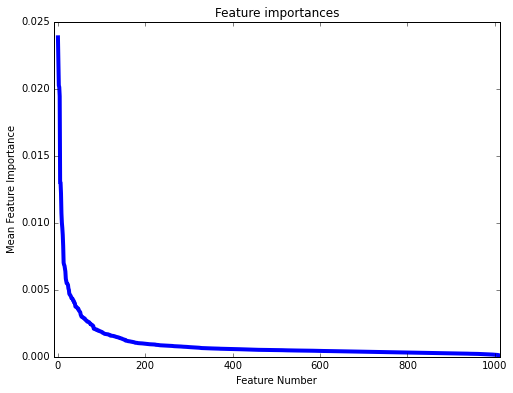

In [8]:
#-----------------------------------------------------------------------------#
# Build predictive model
#-----------------------------------------------------------------------------#
# Split data into 70% training and 30% testing
stratSplit = StratifiedShuffleSplit(classLabel, n_iter=1, test_size=0.3, train_size=0.7, random_state=seed)
for iiTrain, iiTest in stratSplit:
    xTrain, xTest = featHOG[iiTrain, :], featHOG[iiTest, :]
    yTrain, yTest = classLabel[iiTrain], classLabel[iiTest]   
# Build model using the TRAINING dataset
NTrees = 1000 # number of trees in the forest
model = RandomForestClassifier(n_estimators=NTrees, n_jobs=-1, oob_score=True, random_state=seed)
model.fit(xTrain, yTrain)
# Plot importance measure for every feature
impMetric = model.feature_importances_ # extract importance measure
iiImportant = np.argsort(impMetric)[::-1] # indices sorted by importance measure
hFig = plt.figure('Feature Importance', figsize=(8, 6)) 
plt.plot(range(len(impMetric)), impMetric[iiImportant], color="b", linewidth=4)
# Set plot parameters
plt.title("Feature importances")
plt.xlabel('Feature Number')
plt.ylabel('Mean Feature Importance')
plt.xlim([-10, len(impMetric)])
# Out-of-bag error BEFORE feature selection
oobClassLabel = [model.classes_[i] for i in list(model.oob_decision_function_.argmax(axis=1))]
confusionMatrix = confusion_matrix(yTrain, oobClassLabel)
print(confusionMatrix) # rows: actual label, columns: predicted label

## Feature selection

The predictive performance on the (out-of-bag) training dataset is satisfactory suggesting that the model has identified interactions across features that best predict the class of the image. However, the feature importance plot suggests that most of the 1012 HOGs features do not contribute much to the model's predictive capacity. Here we choose to keep only the top 200 HOGs features, re-fit the model and re-evaluate the out-of-bag error.

In [9]:
# Rebuild model based only on the top 200 HOG features
iiTopFeat = iiImportant[0:200] # indices of top 200 features
model = RandomForestClassifier(n_estimators=NTrees, n_jobs=-1, oob_score=True, random_state=seed)
model.fit(xTrain[:, iiTopFeat], yTrain)

# Out-of-bag error AFTER feature selection
oobClassLabel = [model.classes_[i] for i in list(model.oob_decision_function_.argmax(axis=1))]
confusionMatrix = confusion_matrix(yTrain, oobClassLabel)
print(confusionMatrix)

[[31  3  1  0  0]
 [ 4 27  1  0  3]
 [ 0  0 35  0  0]
 [ 0  0  2 32  1]
 [ 0  2  0  1 32]]


With only the top 200 features, the model performs slightly better now on the training dataset. Now that we are happy with the identified model, we can estimate the generalisation error by evaluating the model on the testing dataset.

## Model evaluation

The final step of the modelling process is to estimate the generalisation error. Note that we should **never** tweak/change the model based on information acquired *after* evaluating it on the testing dataset.

[[13  2  0  0  0]
 [ 1 14  0  0  0]
 [ 1  1 12  1  0]
 [ 0  0  2 13  0]
 [ 0  0  0  0 15]]


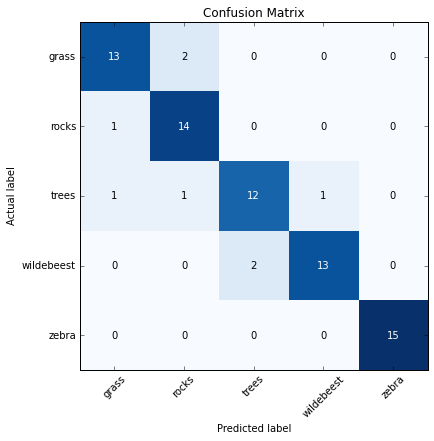

In [10]:
# Evaluate performance on TESTING dataset
confusionMatrix = confusion_matrix(yTest, model.predict(xTest[:, iiTopFeat]), labels=model.classes_)
print(confusionMatrix)   
# Plot confusion matrix
hFig = plt.figure('Confusion Matrix', figsize=(8, 6)) 
plt.imshow(confusionMatrix, interpolation='nearest', cmap=plt.cm.Blues)
# Annotate plot
D = confusionMatrix.shape[0] # no. of rows/columns
for iCol in xrange(D):
    for iRow in xrange(D):
        if iCol==iRow: # change colour for diagonal 
            col='white'
        else:
            col='black'
        plt.text(iCol, iRow, str(confusionMatrix[iRow, iCol]), color=col, 
                 horizontalalignment='center', verticalalignment='center')
plt.title("Confusion Matrix")
tick_marks = np.arange(len(model.classes_))
plt.xticks(tick_marks, model.classes_, rotation=45)
plt.yticks(tick_marks, model.classes_)
plt.tight_layout()
plt.ylabel('Actual label')
plt.xlabel('Predicted label')